___

<a href='http://www.dourthe.tech'> <img src='Dourthe_Technologies_Headers.png' /></a>
___
<center><em>For more information, visit <a href='http://www.dourthe.tech'>www.dourthe.tech</a></em></center>

# Stock Market Forecasting using Deep Recurrent Neural Network

___
## Objective
Train a Deep Recurrent Neural Network (RNN) to predict next day Closing Price of a defined stock by using multivariate historical data and time series segmentation.

___
## Experiments
Several experiments are presented below.

### 1. Google Stock Closing Price Forecasting [Univariate-Single time window]
This experiment only uses the historical closing price of GOOG (univariate).

The model is trained and historical data from January 1st 2005 until one year before current day (i.e. until July 15th 2019) and is tested on the remaining days (until current day -> July 15th 2020).

**NOTE:** Each prediction is made one day into the future, but each prediction made is always using KNOWN data from the specified time window.

**EXAMPLE (with historical window of 90 days/3 months):**
- Prediction on day 1 from test data is generated from KNOWN closing prices from the previous 90 days
- Prediction on day 2 from test data is generated from KNOWN closing prices from the previous 90 days -> we use known data even for the very last point of that second time window and DO NOT USE the prediction made above

As a result, every prediction is always based on KNOWN historical data from previous days. No predicted value is used to build another prediction.

**This means that the plot shown only represents the accuracy of the model at predicting a SINGLE DAY into the future.**

### 2. Google Stock Closing Price Forecasting [Multivariate-Single time window]
This experiment follows the same logic as experiment 1, but includes Low, High, Open, Close and Volume as part of the training data (multivariate) but still tries to predict closing price.

### 3. Next Day Prediction on Single Stock [Multivariate-Multiple time windows-Detailed]
This section was built to train a model on a single stock (to be selected) with no train/test split. The code will import historical data until current day and try to predict closing price for the next day. 

This section also includes the training of 4 models with different segmentation windows (1, 3, 6 months and 1 year).

### 4. Next Day Prediction on Single Stock [Multivariate-Multiple time windows-One script]
This section is identical to section 3, but presented as a single (less detailed) script. 

This section also includes the training of 4 models with different segmentation windows (1, 3, 6 months and 1 year).

### 5. Next Day Prediction on Single Stock [Multivariate-Single time windows-One Script]
This section was built to train a model on a single stock (to be selected) with no train/test split. The code will import historical data until current day and try to predict closing price for the next day.

The difference with sections 3 and 4 is that a single time window is used. Also, the user can select the period during which predictions should be made. The model will be trained using historical data of each data until the day before each prediction is made and will be retrained with an additional day for each new prediction.

The script ends with a chart showing Real vs. Prediction and the possibility to download a DataFrame containing real and predicted values for the defined period.

___
# Libraries import

In [37]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('tensorflow').disabled = True

# Computation time monitoring
import time

# Data processing
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
from datetime import timedelta
from pandas_datareader import data, wb

# Data visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Data normalization
from sklearn.preprocessing import MinMaxScaler

# Neural network architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation
from sklearn.metrics import mean_squared_error

# Download from Google Colab
from google.colab import files

___
# Google Stock Closing Price Forecasting [Univariate-Single time window]
**Here, we will only use the closing price column during training and try to predict closing price for the next day**

## Data import
### Select ticker of the stock you wish to import

In [38]:
ticker = 'GOOG'

### Select start and end dates and import data from Yahoo Fianance

In [39]:
start = datetime(2005,1,1)
end = datetime.today()
stock = data.DataReader(ticker, 'yahoo', start, end)
stock.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-07-29,1531.251953,1501.329956,1506.319946,1522.020020,1106500.0,1522.020020
2020-07-30,1537.869995,1492.219971,1497.000000,1531.449951,1671400.0,1531.449951
2020-07-31,1508.949951,1454.030029,1505.010010,1482.959961,3439900.0,1482.959961
2020-08-03,1490.469971,1465.640015,1486.640015,1474.449951,2330200.0,1474.449951
2020-08-04,1485.560059,1458.650024,1476.569946,1464.969971,1902200.0,1464.969971


### Drop all columns beside the closing price column

In [40]:
stock = stock.drop(['High', 'Low', 'Open', 'Volume', 'Adj Close'], axis=1)
stock.tail()

,Close
Date,
2020-07-29,1522.020020
2020-07-30,1531.449951
2020-07-31,1482.959961
2020-08-03,1474.449951
2020-08-04,1464.969971


### Plot closing price history

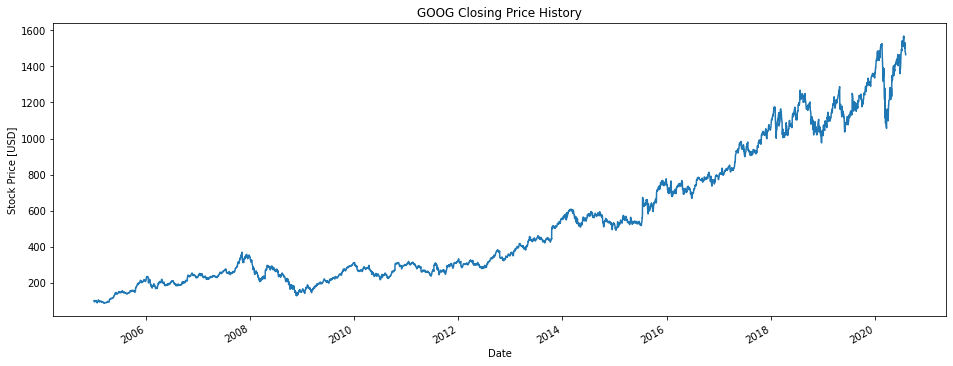

In [41]:
plt.figure(figsize=(16,6))
stock['Close'].plot()
plt.title(ticker + ' Closing Price History')
plt.ylabel('Stock Price [USD]')
plt.show()

## Data pre-processing & Model training
### Choose length of historical data to use to predict next day closing price (in days)
**We will select a window of 3 months (90 days)**

In [42]:
historical_window = 90
days_into_the_future = 1

### Train/Test split
**Select test size (i.e. number of days from the historical data that won't be used to train the model)**

In [43]:
test_size = 12*30

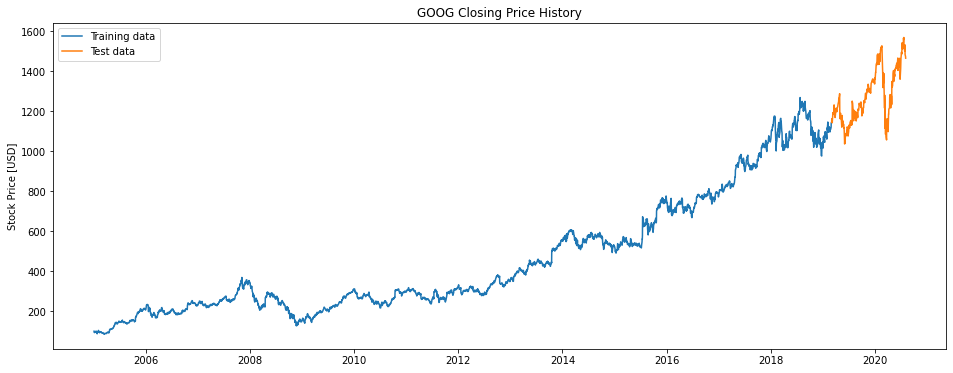

In [44]:
train = stock[:-test_size]
test = stock[-test_size:]

plt.figure(figsize=(16,6))
plt.plot(train['Close'], label='Training data')
plt.plot(test['Close'], label='Test data')
plt.title(ticker + ' Closing Price History')
plt.ylabel('Stock Price [USD]')
plt.legend()
plt.show()

In [45]:
train.tail()

,Close
Date,
2019-02-25,1109.400024
2019-02-26,1115.130005
2019-02-27,1116.050049
2019-02-28,1119.920044
2019-03-01,1140.989990


In [46]:
test.head()

,Close
Date,
2019-03-04,1147.800049
2019-03-05,1162.030029
2019-03-06,1157.859985
2019-03-07,1143.300049
2019-03-08,1142.319946


### Feature scaling

In [47]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

### Reshape data into segments for training

In [48]:
X_train = []
y_train = []
for i in range(historical_window, len(train)):
    X_train.append(train_scaled[i-historical_window:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test = []
y_test = []
for i in range(historical_window, len(test)):
    X_test.append(test_scaled[i-historical_window:i, 0])
    y_test.append(test_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Define and train model on training data (with EarlyStopping callbacks)

In [49]:
model = Sequential()

# Create 1st LSTM layer and some Dropout regularisation
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
# Create 2nd LSTM layer and some Dropout regularisation
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
# Create 3rd LSTM layer and some Dropout regularisation
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
# Create 4th LSTM layer and some Dropout regularisation
model.add(LSTM(units=100))
model.add(Dropout(0.2))

# Create output fully connected layer
model.add(Dense(units=days_into_the_future))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define EarlyStopping callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Fit the model to the training set
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=100, batch_size=32,
          callbacks=[early_stop])

Epoch 1/100
109/109 [==============================] - 3s 28ms/step - loss: 0.0071 - val_loss: 0.0051
Epoch 2/100
109/109 [==============================] - 2s 18ms/step - loss: 0.0015 - val_loss: 0.0132
Epoch 3/100
109/109 [==============================] - 2s 18ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 4/100
109/109 [==============================] - 2s 18ms/step - loss: 0.0013 - val_loss: 0.0076
Epoch 5/100
109/109 [==============================] - 2s 17ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 6/100
109/109 [==============================] - 2s 18ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 7/100
109/109 [==============================] - 2s 18ms/step - loss: 0.0012 - val_loss: 0.0066
Epoch 8/100
109/109 [==============================] - 2s 18ms/step - loss: 9.4475e-04 - val_loss: 0.0069
Epoch 9/100
109/109 [==============================] - 2s 18ms/step - loss: 0.0011 - val_loss: 0.0079
Epoch 10/100
109/109 [==============================] - 2s 17ms/step - loss: 0

### Plot training history

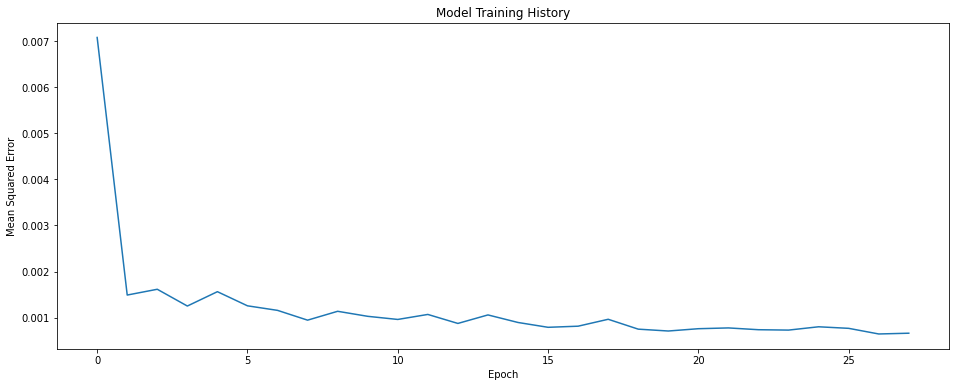

In [50]:
loss = pd.DataFrame(model.history.history)

plt.figure(figsize=(16,6))
loss['loss'].plot()
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.title('Model Training History')
plt.show()

## Generate predictions
**NOTE:** Each prediction is made one day into the future, but each prediction made is always using KNOWN data from the specified time window.

**EXAMPLE (with historical window of 90 days/3 months):**
- Prediction on day 1 from test data is generated from KNOWN closing prices from the previous 90 days
- Prediction on day 2 from test data is generated from KNOWN closing prices from the previous 90 days -> we use known data even for the very last point of that second time window and DO NOT USE the prediction made above

As a result, every prediction is always based on KNOWN historical data from previous days. No predicted value is used to build another prediction.

**This means that the plot shown below only represents the accuracy of the model at predicting a SINGLE DAY into the future.**

In [51]:
scaled_predictions = model.predict(X_test)
predictions = scaler.inverse_transform(scaled_predictions)

predictions = pd.DataFrame(predictions, index=test.index[historical_window:], columns=['Close'])

### Plot predictions

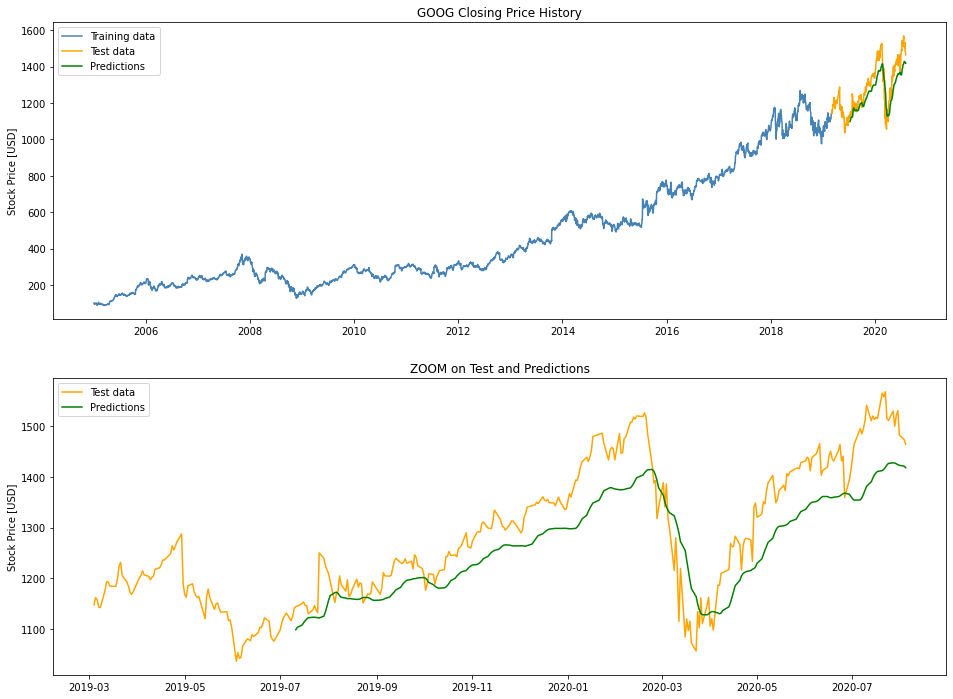

In [52]:
plt.figure(figsize=(16,12))

plt.subplot(211)
plt.plot(train['Close'], color='steelblue', label='Training data')
plt.plot(test['Close'], color='orange', label='Test data')
plt.plot(predictions['Close'], color='green', label='Predictions')
plt.title(ticker + ' Closing Price History')
plt.ylabel('Stock Price [USD]')
plt.legend()

plt.subplot(212)
plt.plot(test['Close'], color='orange', label='Test data')
plt.plot(predictions['Close'], color='green', label='Predictions')
plt.title('ZOOM on Test and Predictions')
plt.ylabel('Stock Price [USD]')
plt.legend()

plt.show()

### Calculate error

In [53]:
rmse = np.round(np.sqrt(mean_squared_error(test.iloc[historical_window:]['Close'], predictions['Close'])), 2)
rmse_ratio = np.round(rmse*100/stock['Close'].max(), 2)
print('Mean Error (RMSE) for all SINGLE DAY predictions:\t', rmse, ' [USD]\t', rmse_ratio, '% of max historical closing price')

Mean Error (RMSE) for all SINGLE DAY predictions:	 75.4  [USD]	 4.81 % of max historical closing price


___
# Google Stock Closing Price Forecasting [Multivariate-Single time window]
**Here, we will only use all columns from the imported data (High, Low, Open, Close, Volume, Adj Close) during training and try to predict closing price for the next day**

Epoch 1/100
109/109 [==============================] - 3s 29ms/step - loss: 0.0056 - val_loss: 0.0106
Epoch 2/100
109/109 [==============================] - 2s 17ms/step - loss: 0.0016 - val_loss: 0.0136
Epoch 3/100
109/109 [==============================] - 2s 18ms/step - loss: 0.0014 - val_loss: 0.0063
Epoch 4/100
109/109 [==============================] - 2s 17ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 5/100
109/109 [==============================] - 2s 18ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 6/100
109/109 [==============================] - 2s 17ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 7/100
109/109 [==============================] - 2s 18ms/step - loss: 0.0012 - val_loss: 0.0057
Epoch 8/100
109/109 [==============================] - 2s 18ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 9/100
109/109 [==============================] - 2s 17ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 10/100
109/109 [==============================] - 2s 17ms/step - loss: 9.852

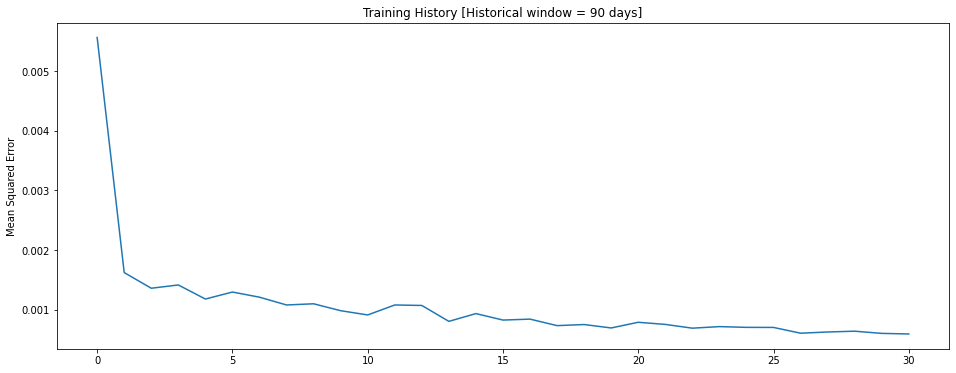

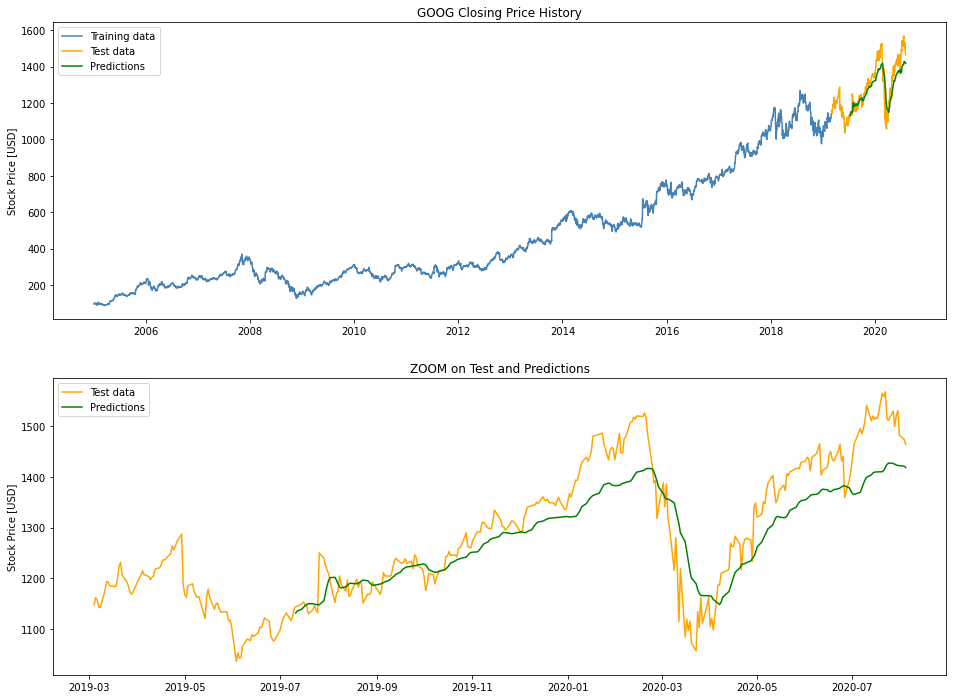

Mean Error (RMSE) for all SINGLE DAY predictions:	 64.37  [USD]	 4.1 % of max historical closing price


In [54]:
# Select ticker
ticker = 'GOOG'

# Select start and end dates of historical data
start = datetime(2005,1,1)
end = datetime.today()

# Import data from Yahoo Finance
stock = data.DataReader(ticker, 'yahoo', start, end).drop(['Adj Close'], axis=1)
close_idx = stock.columns.get_loc('Close')

# Specify historical windows to use for each model
historical_window = 90

# Specify how far into the future to predict (i.e. lag)
days_into_the_future = 1

# Specify test size (i.e. number of days from the historical data that won't be used to train the model)
test_size = 12*30

# Train/Test split
train = stock[:-test_size]
test = stock[-test_size:]

# Feature scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Reshape data into segments for training
X_train = []
y_train = []
for i in range(historical_window, len(train)-days_into_the_future+1):
    X_train.append(train_scaled[i-historical_window:i, :])
    y_train.append(train_scaled[i+days_into_the_future-1, close_idx])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

X_test = []
y_test = []
for i in range(historical_window, len(test)-days_into_the_future+1):
    X_test.append(test_scaled[i-historical_window:i, :])
    y_test.append(test_scaled[i+days_into_the_future-1, 3])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Generate sequential model
model = Sequential()

# Create 1st LSTM layer and some Dropout regularisation
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
# Create 2nd LSTM layer and some Dropout regularisation
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
# Create 3rd LSTM layer and some Dropout regularisation
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
# Create 4th LSTM layer and some Dropout regularisation
model.add(LSTM(units=100))
model.add(Dropout(0.2))

# Create output fully connected layer
model.add(Dense(units=days_into_the_future))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define EarlyStopping callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Fit the model to the training set
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=100, batch_size=32,
          callbacks=[early_stop])
    
# Save loss as dataframe
loss = pd.DataFrame(model.history.history)

plt.figure(figsize=(16,6))

loss['loss'].plot()
plt.ylabel('Mean Squared Error')
plt.title('Training History [Historical window = 90 days]')
plt.show()

# Generate predictions for the whole test period
scaled_predictions = model.predict(X_test)
scaled_predictions = np.transpose([scaled_predictions.reshape(-1)]*X_test.shape[2]).reshape(X_test.shape[0],X_test.shape[2])
# Unscale prediction
predictions = scaler.inverse_transform(scaled_predictions)
predictions = pd.DataFrame(predictions[:,0], index=test.index[historical_window:], columns=['Close'])

# Plot predictions
plt.figure(figsize=(16,12))

plt.subplot(211)
plt.plot(train['Close'], color='steelblue', label='Training data')
plt.plot(test['Close'], color='orange', label='Test data')
plt.plot(predictions['Close'], color='green', label='Predictions')
plt.title(ticker + ' Closing Price History')
plt.ylabel('Stock Price [USD]')
plt.legend()

plt.subplot(212)
plt.plot(test['Close'], color='orange', label='Test data')
plt.plot(predictions['Close'], color='green', label='Predictions')
plt.title('ZOOM on Test and Predictions')
plt.ylabel('Stock Price [USD]')
plt.legend()

plt.show()

rmse = np.round(np.sqrt(mean_squared_error(test.iloc[historical_window:]['Close'], predictions['Close'])), 2)
rmse_ratio = np.round(rmse*100/stock['Close'].max(), 2)
print('Mean Error (RMSE) for all SINGLE DAY predictions:\t', rmse, ' [USD]\t', rmse_ratio, '% of max historical closing price')

___
# Next Day Prediction on Single Stock [Multivariate-Multiple time windows-Detailed]


## Data import
### Select ticker of the stock you wish to import

In [55]:
ticker = 'GNUS'

In [56]:
start = datetime(2014,1,1)
end = datetime.today()
stock = data.DataReader(ticker, 'yahoo', start, end).drop(['Adj Close'], axis=1)
close_idx = stock.columns.get_loc('Close')
stock.tail()

,High,Low,Open,Close,Volume
Date,,,,,
2020-07-29,1.72,1.65,1.719,1.67,16335100.0
2020-07-30,1.64,1.52,1.640,1.59,20235100.0
2020-07-31,1.56,1.43,1.560,1.46,18509300.0
2020-08-03,2.00,1.52,1.530,1.73,111100800.0
2020-08-04,1.81,1.65,1.800,1.69,24497500.0


### Plot closing price history

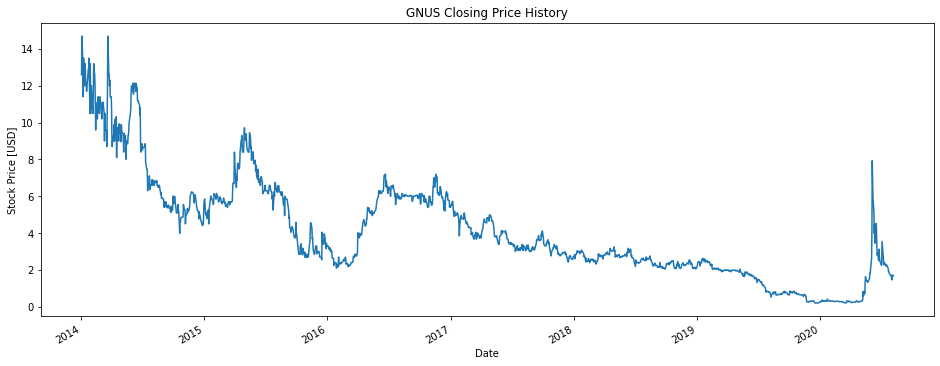

In [57]:
plt.figure(figsize=(16,6))
stock['Close'].plot()
plt.title(ticker + ' Closing Price History')
plt.ylabel('Stock Price [USD]')
plt.show()

## Data pre-processing & Model training
### Choose length of historical data to use to predict next day closing price (in days)
**NOTE:** We will define a list of windows (1, 3, 6 months and 1 year) and train one model for each window and test which model offers the best prediction.

In [58]:
historical_windows = [30, 90, 180, 365]
days_into_the_future = 1

### Feature scaling

In [59]:
scaler = MinMaxScaler()
scaled_stock = scaler.fit_transform(stock)

## In the following cell, we will:
### 1. Reshape data into segments for training
**Each segment in X will contain historical data from as many days as specified by the historical window length (see above) and each corresponding value in y will include the closing price of the day that follows that window.**

**EXAMPLE (with historical window of 30 days/1 month)**
- 1st row in X will have data from day 1 to day 30, and 1st value in y will have data from day 31.
- 2nd row in X will have data from day 2 to day 31, and 2nd value in y will have data from day 32.
- etc.

### 2. Define, compile and train model for each defined historical window
### 3. Save loss into dataframe

In [60]:
for win in historical_windows:
    
    print('\nMODEL with HISTORICAL WINDOW of', win, 'DAYS\n')
    
    X = []
    y = []
    for i in range(win, len(stock)):
        X.append(scaled_stock[i-win:i, :])
        y.append(scaled_stock[i, close_idx])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

    exec('model_' + str(win) + " = Sequential()")

    # Create 1st LSTM layer and some Dropout regularisation
    exec('model_' + str(win) + ".add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1],X.shape[2])))")
    exec('model_' + str(win) + ".add(Dropout(0.2))")
    # Create 2nd LSTM layer and some Dropout regularisation
    exec('model_' + str(win) + ".add(LSTM(units=100, return_sequences=True))")
    exec('model_' + str(win) + ".add(Dropout(0.2))")
    # Create 3rd LSTM layer and some Dropout regularisation
    exec('model_' + str(win) + ".add(LSTM(units=100, return_sequences=True))")
    exec('model_' + str(win) + ".add(Dropout(0.2))")
    # Create 4th LSTM layer and some Dropout regularisation
    exec('model_' + str(win) + ".add(LSTM(units=100))")
    exec('model_' + str(win) + ".add(Dropout(0.2))")

    # Create output fully connected layer
    exec('model_' + str(win) + ".add(Dense(units=days_into_the_future))")

    # Compile model
    exec('model_' + str(win) + ".compile(optimizer='adam', loss='mean_squared_error')")

    # Fit the model to the training set
    exec('model_' + str(win) + ".fit(X, y, epochs=50, batch_size=32)")
    
    # Save loss as dataframe
    exec('loss_' + str(win) + ' = pd.DataFrame(model_' + str(win) + '.history.history)')


MODEL with HISTORICAL WINDOW of 30 DAYS

Epoch 1/50
51/51 [==============================] - 1s 11ms/step - loss: 0.0080
Epoch 2/50
51/51 [==============================] - 0s 9ms/step - loss: 0.0036
Epoch 3/50
51/51 [==============================] - 0s 10ms/step - loss: 0.0033
Epoch 4/50
51/51 [==============================] - 0s 9ms/step - loss: 0.0028
Epoch 5/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0027
Epoch 6/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0029
Epoch 7/50
51/51 [==============================] - 0s 10ms/step - loss: 0.0026
Epoch 8/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0021
Epoch 9/50
51/51 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 10/50
51/51 [==============================] - 0s 10ms/step - loss: 0.0022
Epoch 11/50
51/51 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 12/50
51/51 [==============================] - 0s 9ms/step - loss: 0.001

### Plot training history

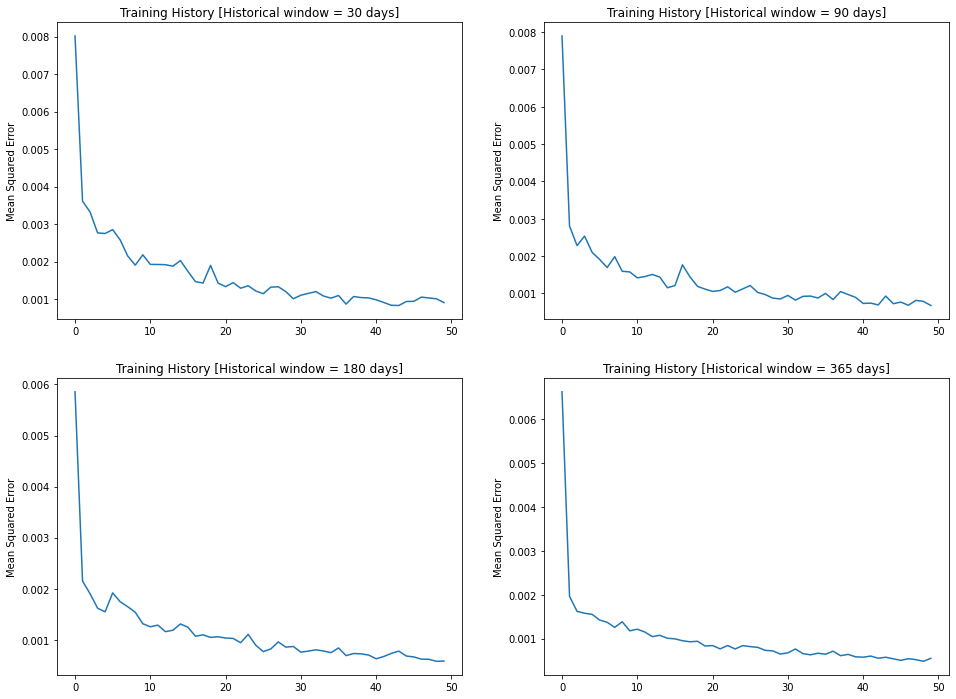

In [61]:
plt.figure(figsize=(16,12))

plt.subplot(221)
loss_30['loss'].plot()
plt.ylabel('Mean Squared Error')
plt.title('Training History [Historical window = 30 days]')

plt.subplot(222)
loss_90['loss'].plot()
plt.ylabel('Mean Squared Error')
plt.title('Training History [Historical window = 90 days]')

plt.subplot(223)
loss_180['loss'].plot()
plt.ylabel('Mean Squared Error')
plt.title('Training History [Historical window = 180 days]')

plt.subplot(224)
loss_365['loss'].plot()
plt.ylabel('Mean Squared Error')
plt.title('Training History [Historical window = 365 days]')

plt.show()

## Generate prediction for upcoming day

In [62]:
# Generate tomorrow's timestamp
tomorrow = stock.index[-1] + timedelta(days=1)
print('\033[1mPredicted Closing Price for', ticker, 'on', tomorrow.strftime("%a. %b. %d, %Y"), '\033[0m')

# Generate prediction using each model trained for different historical windows
for win in historical_windows:
    # Isolate last segment of data
    last_segment = scaled_stock[-win:]
    # Reshape last segment of data to match with the input shape of the RNN
    last_segment = last_segment.reshape((1, last_segment.shape[0], last_segment.shape[1]))
    # Generate scaled prediction
    exec('scaled_prediction_' + str(win) + ' = model_' + str(win) + '.predict(last_segment)')
    if last_segment.shape[1] > 1:
        exec('scaled_prediction_' + str(win) + ' = np.array([scaled_prediction_' + str(win) + ']*scaled_stock.shape[1]).reshape(last_segment.shape[0],-1)')
    # Unscale prediction
    exec('prediction_' + str(win) + ' = scaler.inverse_transform(scaled_prediction_' + str(win) + ')')
    
    # Print prediction
    exec("print('\t[Historical window = " + str(win) + " days]\t', np.round(prediction_" + str(win) + "[0][0], 4), ' USD')")

Predicted Closing Price for GNUS on Wed. Aug. 05, 2020 
	[Historical window = 30 days]	 1.794  USD
	[Historical window = 90 days]	 2.079  USD
	[Historical window = 180 days]	 2.0957  USD
	[Historical window = 365 days]	 1.8431  USD


___
# Next Day Prediction on Single Stock [Multivariate-Multiple time windows-One Script]

MODEL with HISTORICAL WINDOW of 30 DAYS

	Training in progress...
	Training completed in   0 hrs   0 mins  28 secs

MODEL with HISTORICAL WINDOW of 90 DAYS

	Training in progress...
	Training completed in   0 hrs   0 mins  45 secs

MODEL with HISTORICAL WINDOW of 180 DAYS

	Training in progress...
	Training completed in   0 hrs   1 mins  12 secs

MODEL with HISTORICAL WINDOW of 365 DAYS

	Training in progress...
	Training completed in   0 hrs   1 mins  59 secs



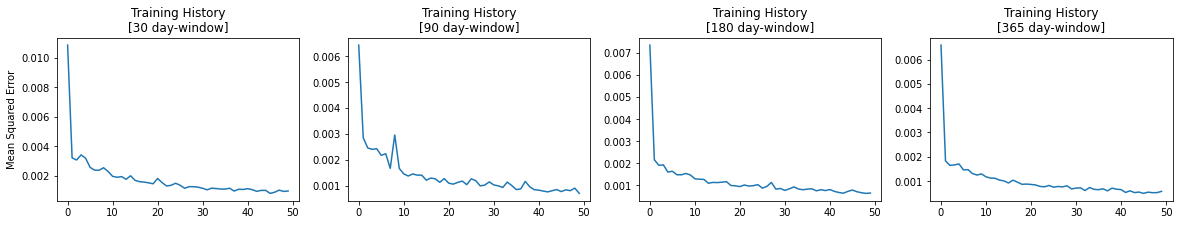


Predicted Closing Price for GNUS on Wed. Aug. 05, 2020 
	[Historical window =  30 days]	    2.27 USD	(up by    34.38 %)
	[Historical window =  90 days]	    2.17 USD	(up by    28.46 %)
	[Historical window = 180 days]	    2.31 USD	(up by    36.91 %)
	[Historical window = 365 days]	    2.07 USD	(up by    22.73 %)

Total computation time:   0 hrs   4 mins  29 secs


In [63]:
# Set total time tracker
total_start_time = time.time()

# Select ticker
ticker = 'GNUS'

# Select start and end dates of historical data
start = datetime(2014,1,1)
end = datetime.today()

# Specify historical windows to use for each model
historical_windows = [30, 90, 180, 365]

# Specify how far into the future to predict (i.e. lag)
days_into_the_future = 1

# Import data from Yahoo Finance (option to drop certain columns) (for univariate -> drop(['High', 'Low', 'Open', 'Volume', 'Adj Close'], axis=1))
stock = data.DataReader(ticker, 'yahoo', start, end).drop(['Adj Close'], axis=1)
close_idx = stock.columns.get_loc('Close')

# Normalize data
scaler = MinMaxScaler()
scaled_stock = scaler.fit_transform(stock)

# Loop through all historical windows and generate and train one model for each window
for win in historical_windows:
    start_time = time.time()
    print('MODEL with HISTORICAL WINDOW of', win, 'DAYS')
    print('\n\tTraining in progress...')
    X = []
    y = []
    # Segment data
    for i in range(win, len(stock)-days_into_the_future+1):
        X.append(scaled_stock[i-win:i, :])
        y.append(scaled_stock[i+days_into_the_future-1, close_idx])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

    # Generate sequential model
    exec('model_' + str(win) + " = Sequential()")
    # Create 1st LSTM layer and some Dropout regularisation
    exec('model_' + str(win) + ".add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1],X.shape[2])))")
    exec('model_' + str(win) + ".add(Dropout(0.2))")
    # Create 2nd LSTM layer and some Dropout regularisation
    exec('model_' + str(win) + ".add(LSTM(units=100, return_sequences=True))")
    exec('model_' + str(win) + ".add(Dropout(0.2))")
    # Create 3rd LSTM layer and some Dropout regularisation
    exec('model_' + str(win) + ".add(LSTM(units=100, return_sequences=True))")
    exec('model_' + str(win) + ".add(Dropout(0.2))")
    # Create 4th LSTM layer and some Dropout regularisation
    exec('model_' + str(win) + ".add(LSTM(units=100))")
    exec('model_' + str(win) + ".add(Dropout(0.2))")
    # Create output fully connected layer
    exec('model_' + str(win) + ".add(Dense(units=days_into_the_future))")

    # Compile model
    exec('model_' + str(win) + ".compile(optimizer='adam', loss='mean_squared_error')")

    # Fit the model to the training set
    exec('model_' + str(win) + ".fit(X, y, epochs=50, batch_size=32, verbose=0)")
    
    # Save loss as dataframe
    exec('loss_' + str(win) + ' = pd.DataFrame(model_' + str(win) + '.history.history)')

    # Print computation time
    current_time = time.time()-start_time
    print(f'\tTraining completed in {current_time//3600:3.0f} hrs {(current_time - current_time//3600*3600)//60:3.0f} mins {current_time%60:3.0f} secs\n')

# Plot training history
plt.figure(figsize=(20,3))
plt.subplot(141)
loss_30['loss'].plot()
plt.ylabel('Mean Squared Error')
plt.title('Training History\n[30 day-window]')
plt.subplot(142)
loss_90['loss'].plot()
plt.title('Training History\n[90 day-window]')
plt.subplot(143)
loss_180['loss'].plot()
plt.title('Training History\n[180 day-window]')
plt.subplot(144)
loss_365['loss'].plot()
plt.title('Training History\n[365 day-window]')
plt.show()

# Generate tomorrow's timestamp
tomorrow = stock.index[-1] + timedelta(days=days_into_the_future)
if tomorrow.strftime("%a") == 'Sat':
    tomorrow = tomorrow + timedelta(days=2)  
print(f'\033[1m\nPredicted Closing Price for {ticker} on {tomorrow.strftime("%a. %b. %d, %Y")} \033[0m')

# Generate prediction using each model trained for different historical windows
for win in historical_windows:
    # Isolate last segment of data
    last_segment = scaled_stock[-win:]
    # Reshape last segment of data to match with the input shape of the RNN
    last_segment = last_segment.reshape((1, last_segment.shape[0], last_segment.shape[1]))
    # Generate scaled prediction
    exec('scaled_prediction_' + str(win) + ' = model_' + str(win) + '.predict(last_segment)')
    if last_segment.shape[1] > 1:
        exec('scaled_prediction_' + str(win) + ' = np.array([scaled_prediction_' + str(win) + ']*scaled_stock.shape[1]).reshape(last_segment.shape[0],-1)')
    # Unscale prediction
    exec('prediction_' + str(win) + ' = scaler.inverse_transform(scaled_prediction_' + str(win) + ')')
    
    # Calculate increase/decrease from previous day (in %)
    previous_day = stock['Close'][-1]
    exec("change = (prediction_" + str(win) + "[0][0] - previous_day)*100/previous_day")

    # Print prediction
    if change > 0:
        exec("print(f'\t[Historical window = {win:3.0f} days]\t" + "{prediction_" + str(win) + "[0][0]:8.2f} USD\t(up by {change:8.2f} %)')")
    else:
        exec("print(f'\t[Historical window = {win:3.0f} days]\t" + "{prediction_" + str(win) + "[0][0]:8.2f} USD\t(down by {change:6.2f} %)')")

total_time = time.time() - total_start_time
print(f'\nTotal computation time: {total_time//3600:3.0f} hrs {(total_time - total_time//3600*3600)//60:3.0f} mins {total_time%60:3.0f} secs')

___
# Next Day Prediction on Single Stock [Multivariate-Single time window-One Script]

MODEL with HISTORICAL WINDOW of 90 DAYS

	Training in progress...
	Training completed in   0 hrs   0 mins  56 secs

		Predicted Closing Price for GOOG on Wed. Jul. 01, 2020 	 1381.08 USD	(🡖 by -2.30 %)

	Training in progress...
	Training completed in   0 hrs   0 mins  52 secs

		Predicted Closing Price for GOOG on Thu. Jul. 02, 2020 	 1401.39 USD	(🡖 by -2.55 %)

	Training in progress...
	Training completed in   0 hrs   0 mins  59 secs

		Predicted Closing Price for GOOG on Mon. Jul. 06, 2020 	 1439.77 USD	(🡖 by -1.70 %)

	Training in progress...
	Training completed in   0 hrs   0 mins  56 secs

		Predicted Closing Price for GOOG on Tue. Jul. 07, 2020 	 1369.97 USD	(🡖 by -8.41 %)

	Training in progress...
	Training completed in   0 hrs   0 mins  57 secs

		Predicted Closing Price for GOOG on Wed. Jul. 08, 2020 	 1440.48 USD	(🡖 by -3.01 %)

	Training in progress...
	Training completed in   0 hrs   0 mins  56 secs

		Predicted Closing Price for GOOG on Thu. Jul. 09, 2020 	 1480.78 USD	(🡖 

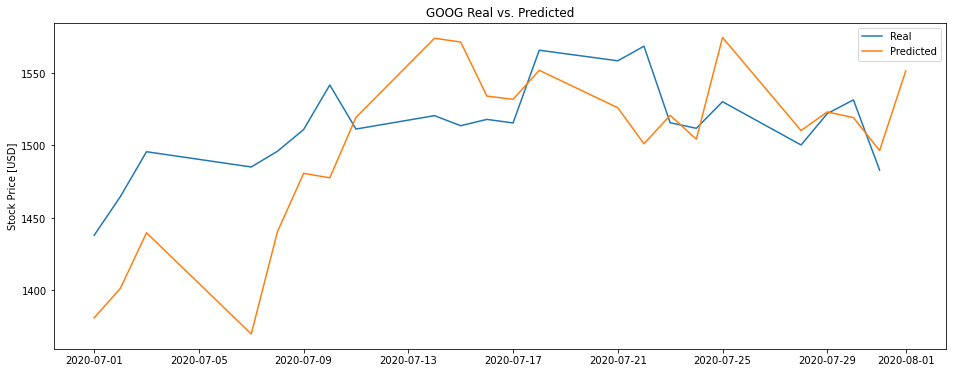

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Total computation time:   0 hrs  22 mins  14 secs


In [64]:
# Set total time tracker
total_start_time = time.time()

# Select ticker
ticker = 'GOOG'

# Select start and end dates of historical data
start = datetime(2012,1,1)
end = datetime(2020,8,2)

# Import data from Yahoo Finance (option to drop certain columns) (for univariate -> drop(['High', 'Low', 'Open', 'Volume', 'Adj Close'], axis=1))
stock_full_history = data.DataReader(ticker, 'yahoo', start, end).drop(['Adj Close'], axis=1)
close_idx = stock_full_history.columns.get_loc('Close')

# Select time period for predictions
period = stock_full_history.loc['2020-06-30':'2020-07'].index

# Specify historical windows to use
win = 90

# Specify how far into the future to predict (i.e. lag)
days_into_the_future = 1

# Initialize lists to store predictions
real_list = []
prediction_list = []
change_list = []

print('MODEL with HISTORICAL WINDOW of', win, 'DAYS')

for p in range(len(period)):

    print('\n\tTraining in progress...')

    # Select historical data up until certain day to train model and predict for following day
    stock = stock_full_history.loc[:period[p]]

    # Normalize data
    scaler = MinMaxScaler()
    scaled_stock = scaler.fit_transform(stock)

    # Loop through all historical windows and generate and train one model for each window
    start_time = time.time()
    X = []
    y = []
    # Segment data
    for i in range(win, len(stock)-days_into_the_future+1):
        X.append(scaled_stock[i-win:i, :])
        y.append(scaled_stock[i+days_into_the_future-1, close_idx])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

    # Generate sequential model
    model = Sequential()
    # Create 1st LSTM layer and some Dropout regularisation
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1],X.shape[2])))
    model.add(Dropout(0.2))
    # Create 2nd LSTM layer and some Dropout regularisation
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    # Create 3rd LSTM layer and some Dropout regularisation
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    # Create 4th LSTM layer and some Dropout regularisation
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    # Create output fully connected layer
    model.add(Dense(units=days_into_the_future))

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model to the training set
    model.fit(X, y, epochs=50, batch_size=32, verbose=0)

    # Save loss as dataframe
    loss = pd.DataFrame(model.history.history)

    # Print computation time
    current_time = time.time()-start_time
    print(f'\tTraining completed in {current_time//3600:3.0f} hrs {(current_time - current_time//3600*3600)//60:3.0f} mins {current_time%60:3.0f} secs\n')

    # Generate following day's timestamp
    if p == len(period)-1:
        tomorrow = stock.index[-1] + timedelta(days=days_into_the_future)
    else:
        tomorrow = period[p+1]
    if tomorrow.strftime("%a") == 'Sat':
        tomorrow = tomorrow + timedelta(days=2)  

    # Generate prediction using each model trained for different historical windows
    # Isolate last segment of data
    last_segment = scaled_stock[-win:]
    # Reshape last segment of data to match with the input shape of the RNN
    last_segment = last_segment.reshape((1, last_segment.shape[0], last_segment.shape[1]))
    # Generate scaled prediction
    scaled_prediction = model.predict(last_segment)
    if last_segment.shape[1] > 1:
        scaled_prediction = np.array([scaled_prediction]*scaled_stock.shape[1]).reshape(last_segment.shape[0],-1)
    # Unscale prediction
    prediction = scaler.inverse_transform(scaled_prediction)

    # Calculate increase/decrease from previous day (in %)
    previous_day = stock['Close'][-1]
    change = (prediction[0][0] - previous_day)*100/previous_day

    # Print prediction
    if change > 0:
        print(f'\033[1m\t\tPredicted Closing Price for {ticker} on {tomorrow.strftime("%a. %b. %d, %Y")} \033[0m\t{prediction[0][0]:8.2f} USD\t(🡕 by {change:3.2f} %)')
    else:
        print(f'\033[1m\t\tPredicted Closing Price for {ticker} on {tomorrow.strftime("%a. %b. %d, %Y")} \033[0m\t{prediction[0][0]:8.2f} USD\t(🡖 by {change:3.2f} %)')

    # Append real price, prediction and corresponding predicted change
    if p != len(period)-1:
        real_list.append(stock_full_history.loc[period[p+1]]['Close'])
    else:
        real_list.append(np.nan)
    prediction_list.append(prediction[0][0])
    change_list.append(change)

# Generate dataframe
prediction_period = period + timedelta(1)
df = pd.DataFrame(np.transpose([real_list, prediction_list, change_list]), columns=['real [$]', 'predicted [$]', 'predicted change [%]'], index=prediction_period)

# Plot Real vs. Predictions
plt.figure(figsize=(16,6))
plt.plot(df['real [$]'], label='Real')
plt.plot(df['predicted [$]'], label='Predicted')
plt.title(ticker + ' Real vs. Predicted')
plt.ylabel('Stock Price [USD]')
plt.legend()
plt.show()

# Set filename
filename = ticker + '_' + str(win) + '-day-model_' + prediction_period[0].strftime("%Y-%b-%d") + '_to_' + prediction_period[-1].strftime("%Y-%b-%d") + '.csv'
df.to_csv(filename) 

# Download file (if script ran via Google Colab)
files.download(filename)

# Print total computation time
total_time = time.time() - total_start_time
print(f'\nTotal computation time: {total_time//3600:3.0f} hrs {(total_time - total_time//3600*3600)//60:3.0f} mins {total_time%60:3.0f} secs')

___
# Conclusion
While it was interesting to implement a Deep Recurrent Neural Network (DRNN) to forecast stock market prices, it should be acknowledged that this approach is far from sufficient to make realistic predictions.

This project showed that a DRNN has the potential to capture certain historical trends, but it should also be noted that the current approach only allows predictions up to one day into the future. In addition, the model was not always right with respect to changes in price (i.e. up or down by X%), which indicates that it would not be a reliable method to make bids.

In conclusion, it is a known fact that the stock market is somewhat unpredictable and that potential changes in stock price is not only impacted by historical trends, but also by many other parameters that are often hard to quantify.